In [ ]:
# To avoid the error while plotting "AttributeError: 'GeoAxes' object has no attribute '_autoscaleXon'"
!pip install --user matplotlib==3.5.2

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.patches import Rectangle

import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature

from osgeo import gdal

from nansat import Nansat, Domain, NSR

from sea_ice_drift.lib import get_spatial_mean, get_uint8_image
from sea_ice_drift.ftlib import feature_tracking
from sea_ice_drift.pmlib import pattern_matching
from sea_ice_drift.libdefor import get_deformation_nodes

import xarray as xr

import csv

%matplotlib inline

**Stored variables**

**For using sar subset for model extraction**
- r
- c
- X_subset
- Y_subset
- lat_subset
- lon_subset
- proj4

**For plotting**
- siconc_subset (for ens 8, check and maybe change it to 24ens mean from another notebook)

**For using SAR drift algorithm reference data in other notebooks**
- upm
- vpm
- apm
- rpm
- hpm
- lon2pm
- lat2pm
- lon1pm
- lat1pm

In [2]:
# Download arrays

f1 = gdal.Open(r'/home/jovyan/data/SAR_images/S1A_EW_GRDM_1SDH_20221119T072104_20221119T072208_045960_057FE5_E8B1_Orb_Cal_TC_HV.tif')
f2 = gdal.Open(r'/home/jovyan/data/SAR_images/S1A_EW_GRDM_1SDH_20221120T080155_20221120T080259_045975_05805E_51E1_Orb_Cal_TC_HV.tif')
#f1 = gdal.Open(r'/home/jovyan/data/SAR_images/subset_of_S1A_EW_GRDM_1SDH_20221119T072104_20221119T072208_045960_057FE5_E8B1_Orb_Cal_TC_HV.tif')
#f2 = gdal.Open(r'/home/jovyan/data/SAR_images/subset_of_S1A_EW_GRDM_1SDH_20221120T080155_20221120T080259_045975_05805E_51E1_Orb_Cal_TC_HV.tif')
f3 = gdal.Open(r'/home/jovyan/data/SAR_images_forecast/Forecasted_20221119T08_subset_of_S1A_EW_GRDM_1SDH_20221119T072104_20221119T072208_045960_057FE5_E8B1_Orb_Cal_TC_HV.tif')

In [3]:
#Load the data from the files into numpy arrays for further processing.
a1 = f1.ReadAsArray() 
a2 = f2.ReadAsArray()
a3 = f3.ReadAsArray()

#Pre-process images to ensure consistent visualization and handle blank spots issue after pattern patching.

a1 = get_uint8_image(a1, None, None, 1, 99)
a2 = get_uint8_image(a2, None, None, 1, 99)
a3 = get_uint8_image(a3, None, None, 1, 99)

VMIN:  0.0
VMAX:  0.01902542145922781
VMIN:  0.0
VMAX:  0.02425714209675789
VMIN:  0.0006377207930199802
VMAX:  0.02119946330785752


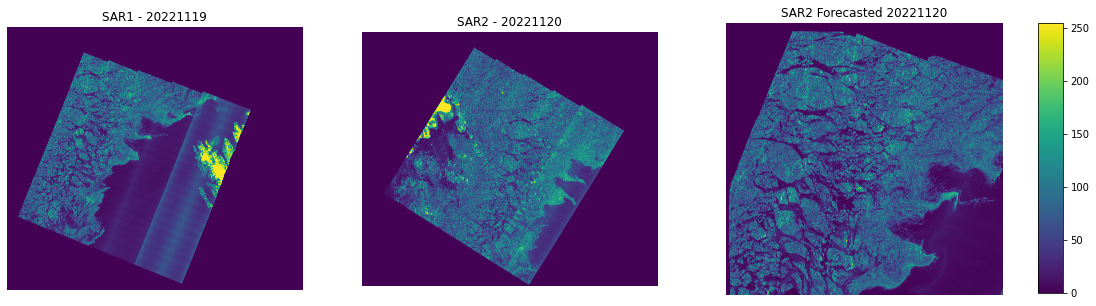

In [4]:
#Plot
fig, ax = plt.subplots(1,3, figsize=(18,5))
im1 = ax[0].imshow(a1, clim=[0, 255])
ax[0].axis('off')
#plt.colorbar(im0, ax=ax[0])
im2 = ax[1].imshow(a2, clim=[0, 255])
ax[1].axis('off')
#plt.colorbar(im1, ax=ax[1])
im3 = ax[2].imshow(a3, clim=[0, 255])
ax[2].axis('off')
cax = fig.add_axes([0.92, 0.13, 0.02, 0.75])  # Position and size of the colorbar
cbar = fig.colorbar(im3, cax=cax)
#plt.colorbar(im3, ax=ax[2])

ax[0].set_title("SAR1 - 20221119")
ax[1].set_title("SAR2 - 20221120")
ax[2].set_title("SAR2 Forecasted 20221120")

plt.show()

In [5]:
# Create three Nansat objects with original tiff georeference imported from gdal object.
srs_tiff = f1.GetSpatialRef() 

rows, cols = a1.shape
d_sar = Domain(srs_tiff, ds=f1)
n1 = Nansat.from_domain(d_sar, a1)
n2 = Nansat.from_domain(d_sar, a2)
n3 = Nansat.from_domain(d_sar, a3)

In [6]:
# Close the dataset
f1 = None
f2 = None
f3 = None

In [7]:
# Run Feature Tracking between SAR1 and SAR2 
# get start/end coordinates in the image coordinate system (colums/rows)  
c1, r1, c2, r2 = feature_tracking(n1, n2, nFeatures=20000, ratio_test=0.6, max_drift=100000, verbose=True)

Key points found: 20000
Key points found: 20000
Domain filter: 20000 -> 20000
Domain filter: 20000 -> 20000
Keypoints matched 0.8071334362030029
Ratio test 0.600000 found 144 keypoints
MaxDrift filter: 144 -> 0


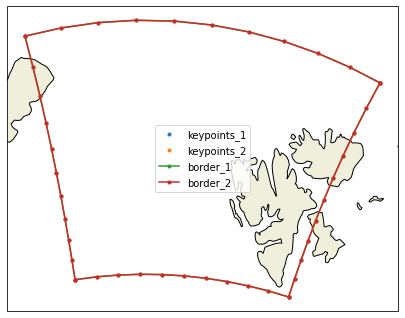

In [8]:
# Plot identified and matched keypoints in geographic coordinates for SAR1 and SAR2 

# convert row/column coordinates of matched features to lon/lat
lon1ft, lat1ft = n1.transform_points(c1, r1)
lon2ft, lat2ft = n2.transform_points(c2, r2)

# get lon/lat coordinates of the border of images
lon1b, lat1b = n1.get_border()
lon2b, lat2b = n2.get_border()


# get hi-res landmask
land_50m = cfeature.NaturalEarthFeature('physical', 'land', '50m',
                                        edgecolor='face',
                                        facecolor=cfeature.COLORS['land'])

plt.figure(figsize=(7,7))
ax = plt.axes(projection=ccrs.Mercator())
ax.add_feature(land_50m, zorder=0, edgecolor='black')
ax.plot(lon1ft, lat1ft, '.', label='keypoints_1', transform=ccrs.PlateCarree())
ax.plot(lon2ft, lat2ft, '.', label='keypoints_2', transform=ccrs.PlateCarree())
ax.plot(lon1b, lat1b, '.-', label='border_1', transform=ccrs.PlateCarree())
ax.plot(lon2b, lat2b, '.-', label='border_2', transform=ccrs.PlateCarree())

ax.legend()
plt.show()

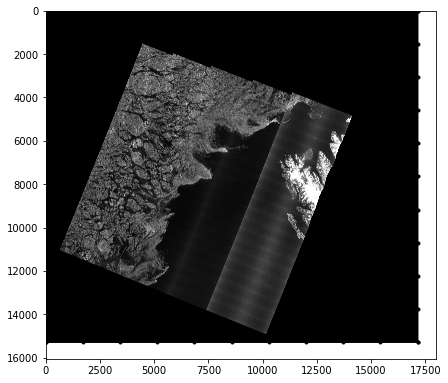

In [9]:
# Plot ice drift on top of image_1 for SAR1 and SAR2 

# end points in image_1 coordinate system
n1c2, n1r2 = n1.transform_points(lon2ft, lat2ft, DstToSrc=1)

# ice drift components in image_1 coordinate system
dr = n1r2 - r1
dc = n1c2 - c1

# border of image_2 in image_1 coordinate system
n1lon2b, n1lat2b = n1.transform_points(lon2b, lat2b, DstToSrc=1)

# plot of ice drift. Arrows are 5 times longer than actual drift
plt.figure(figsize=(7,7))
plt.imshow(n1[1], cmap='gray')
plt.quiver(c1, r1, dc, dr, color='r', angles='xy', scale_units='xy', scale=0.5)
plt.plot(n1lon2b, n1lat2b, 'k.-')
plt.show()

In [11]:
import xarray as xr
# Setting subset grid using image border coordinates from nanset object
# Open the remote dataset with model data
data = xr.open_dataset("https://thredds.met.no/thredds/dodsC/fou-hi/barents_eps_eps/barents_eps_20221119T06Z.nc")

# Extract X and Y coordinates, as well as longitude and latitude values from the dataset
X = data['X']
Y = data['Y']
lon = data['lon']
lat = data['lat']

# Retrieve the proj4 string defining the Lambert Conformal projection of the dataset
proj4 = data.projection_lambert.proj4
print(proj4)

# Convert the proj4 string to a Nansat spatial reference object
srs = NSR(proj4)


#Get bound in rows and columns correspoding to the image borders set above
r,c = np.where((lon.data > min(lon1b))*(lon.data <  max(lon1b))*(lat.data >  min(lat1b))*(lat.data < max(lat1b)))
               
min(r), max(r), min(c), max(c)

+proj=lcc +lat_0=77.5 +lon_0=-25 +lat_1=77.5 +lat_2=77.5 +no_defs +R=6.371e+06


(460, 613, 2, 161)

In [12]:
# Extract the subset grif out of the model grid based on the image bounds
#That grid and srs will be used for pattern matching ensuring the drift output aligns easily with the model data.
X_subset = X[min(c):max(c)+1]
Y_subset = Y[min(r):max(r)+1]
lon_subset = lon[min(r):max(r)+1, min(c):max(c)+1]
lat_subset = lat[min(r):max(r)+1, min(c):max(c)+1]


# Prepare coordinates for patern matching input
lon1pm = lon_subset.data
lat1pm = lat_subset.data

# Set up coordinates in meters for visualizing the pattern matching results.
x1pm, y1pm = np.meshgrid(X_subset, Y_subset)

In [13]:
X_subset.shape, Y_subset.shape, r.shape, c.shape, lon_subset.shape, lon_subset.shape

((160,), (154,), (14002,), (14002,), (154, 160), (154, 160))

In [14]:
#Store variables to use in model_drift_export for subset
%store r
%store c
%store X_subset
%store Y_subset
%store lat_subset
%store lon_subset
%store proj4

Stored 'r' (ndarray)
Stored 'c' (ndarray)
Stored 'X_subset' (DataArray)
Stored 'Y_subset' (DataArray)
Stored 'lat_subset' (DataArray)
Stored 'lon_subset' (DataArray)
Stored 'proj4' (str)


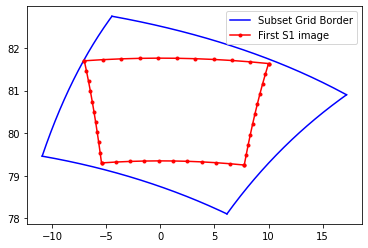

In [15]:
# Plot coverage of the first SAR1 image and subset grid imported from the model
# Top border
plt.plot(lon_subset[0, :], lat_subset[0, :], 'b-', label='Subset Grid Border')
# Bottom border
plt.plot(lon_subset[-1, :], lat_subset[-1, :], 'b-')
# Left border
plt.plot(lon_subset[:, 0], lat_subset[:, 0], 'b-')
# Right border
plt.plot(lon_subset[:, -1], lat_subset[:, -1], 'b-')

plt.plot(*n1.get_border(), '.-', label='First S1 image', c = 'red')
#plt.plot(*dom_pm.get_border(), '.-', label='ROI')
plt.legend()
plt.show()

In [16]:
# Run Pattern Matching for each element in lon1pm/lat1pm matrix
# ice displacement upm and vpm are returned in meters in Mercator (faked) projection
upm, vpm, apm, rpm, hpm, lon2pm, lat2pm = pattern_matching(lon1pm, lat1pm, n1, c1, r1, n2, c2, r2, angles=[-12,-10,-7,-5,-3,0,3,5,7, 10,12],
                                                          srs=srs.ExportToProj4())

/home/jovyan/work/nersc_drift_algorithm/sea_ice_drift/pmlib.py:57: RuntimeWarning: invalid value encountered in divide
  hes = (hes - np.median(hes)) / np.std(hes)


/home/jovyan/work/nersc_drift_algorithm/sea_ice_drift/pmlib.py:57: RuntimeWarning: invalid value encountered in divide
  hes = (hes - np.median(hes)) / np.std(hes)


/home/jovyan/work/nersc_drift_algorithm/sea_ice_drift/pmlib.py:57: RuntimeWarning: invalid value encountered in divide
  hes = (hes - np.median(hes)) / np.std(hes)


/home/jovyan/work/nersc_drift_algorithm/sea_ice_drift/pmlib.py:57: RuntimeWarning: invalid value encountered in divide
  hes = (hes - np.median(hes)) / np.std(hes)


/home/jovyan/work/nersc_drift_algorithm/sea_ice_drift/pmlib.py:57: RuntimeWarning: invalid value encountered in divide
  hes = (hes - np.median(hes)) / np.std(hes)


90% 03149.0 00331.0 03204.0 00436.0 +00.0 0.69 8.161
 Pattern matching - OK! ( 19 sec)


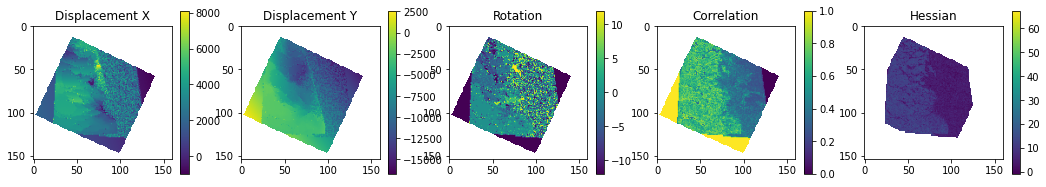

In [17]:
# plot retrieved matrices
titles = ['Displacement X', 'Displacement Y', 'Rotation', 'Correlation', 'Hessian']
fig, ax = plt.subplots(1,5, figsize=(18,3))

for i, a in enumerate([upm, vpm, apm, rpm, hpm]):
    ax[i].set_title(titles[i])
    im = ax[i].imshow(a) 
    plt.colorbar(im, ax=ax[i])


plt.show()

###  Processing the algorithm output and visualizing with SAR image

#### Filtering with hessian

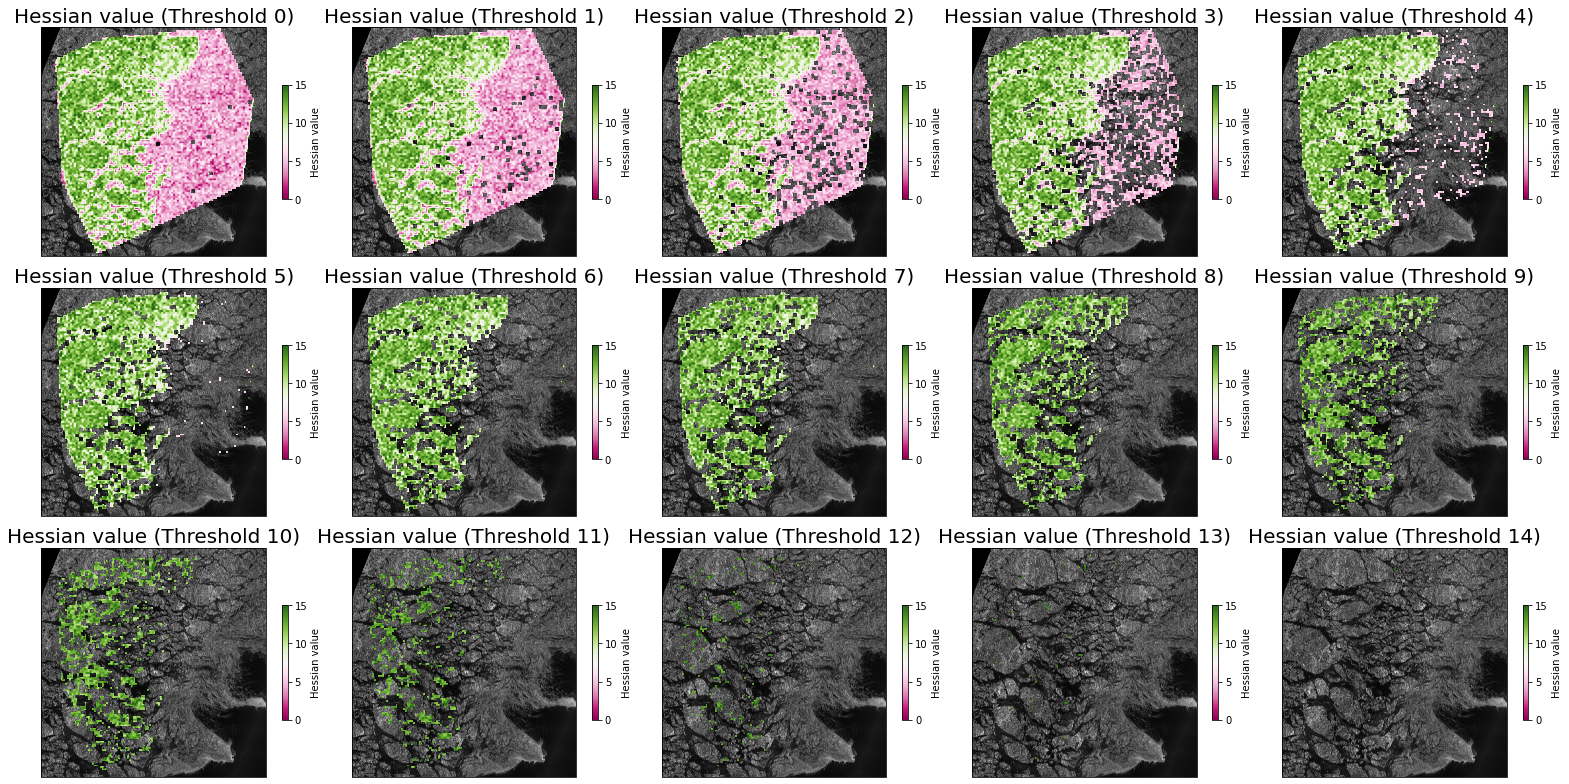

In [18]:
# spacial reference for plotting
crs = ccrs.LambertConformal(central_longitude=-25,
    central_latitude=77.5,
    false_easting=0.0,
    false_northing=0.0,
    secant_latitudes=None,
    standard_parallels=(77.5, 77.5),
    globe=None)

# Create a figure with a 2x5 grid of subplots
#fig, axs = plt.subplots(nrows=5, ncols=3, figsize=(30, 50), subplot_kw={'projection': crs})
fig, axs = plt.subplots(nrows=3, ncols=5, figsize=(22, 11), subplot_kw={'projection': crs})
fig.subplots_adjust(hspace=0.5)  # Adjust vertical spacing between subplots

for i, ax in enumerate(axs.flat):
    threshold = i  # Adjust threshold value based on subplot index
    gpi = (rpm > threshold)
    num_true_values = np.sum(gpi)
    #print(f"Number of True values in gpi for threshold {threshold}: {num_true_values}")

    # Filter out values of hpm less than the current threshold
    filtered_hpm = np.where(hpm > threshold, hpm, np.nan)
    ax.imshow(n1[1], cmap='gray', extent=[x1pm.min(), x1pm.max(), y1pm.min(), y1pm.max()], origin='upper')
    h_img = ax.imshow(filtered_hpm, extent=[x1pm.min(), x1pm.max(), y1pm.min(), y1pm.max()], origin='lower', cmap='PiYG', alpha=1, vmin=0, vmax=15)
    ax.set_title(f'Hessian value (Threshold {threshold})', fontsize=20)
    ax.add_feature(land_50m, edgecolor='black')
    ax.set_xlim([x1pm.min() + 40000, x1pm.max() - 70000])
    ax.set_ylim([y1pm.min() + 30000, y1pm.max() - 60000])
    plt.colorbar(h_img, ax=ax, label='Hessian value', shrink=0.5)
    #RdYlBu

plt.tight_layout()
plt.show()

##### Calculating the threshold

In [112]:
np.nanmax(hpm)

67.34762573242188

In [139]:
# Importing hpm values for calculating a threshold using Gaussian Mixture Model method'
# See notebook "Hessian_threshold_choice.ipynb"

hpm_class = hpm.flatten()
hpm_class = hpm_class[~np.isnan(hpm_class)]
%store hpm_class

import csv 
save_path = r'/home/jovyan/data/SAR_drift_output/hpm_class.csv'

points = hpm_class.reshape(-1, 1)
header = ['hpm']
file_path = save_path

#Open the CSV file for writing              
with open(file_path, 'w', newline='') as csv_file:
    out = csv.writer(csv_file, delimiter=',')
    out.writerow(header)
    out.writerows(points)

Stored 'hpm_class' (ndarray)


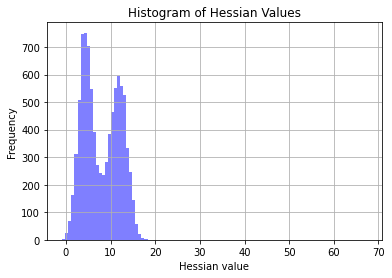

In [140]:
# Create a histogram for hpm
plt.hist(hpm.flatten(), bins=100, color='blue', alpha=0.5)  # You can adjust the number of bins as needed
plt.xlabel('Hessian value')
plt.ylabel('Frequency')
plt.title('Histogram of Hessian Values')
plt.grid(True)
plt.show()


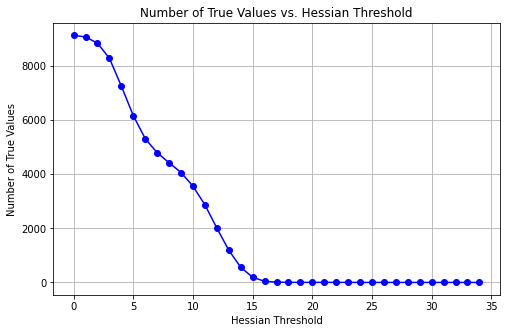

In [142]:
import matplotlib.pyplot as plt

# Lists to store threshold values and corresponding num_true_values
thresholds = []
num_true_values_list = []

# Loop through different threshold values
for threshold in range(0, 35):  # Adjust the range as needed
    gpi = (hpm > threshold)
    num_true_values = np.sum(gpi)
    thresholds.append(threshold)
    num_true_values_list.append(num_true_values)

# Create the line plot
plt.figure(figsize=(8, 5))
plt.plot(thresholds, num_true_values_list, marker='o', linestyle='-', color='b')
plt.xlabel('Hessian Threshold')
plt.ylabel('Number of True Values')
plt.title('Number of True Values vs. Hessian Threshold')
plt.grid(True)
plt.show()


#### Filtering with correlation

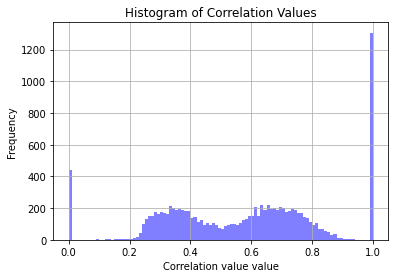

In [137]:
import matplotlib.pyplot as plt

# Create a histogram for hpm
plt.hist(rpm.flatten(), bins=100, color='blue', alpha=0.5)  # You can adjust the number of bins as needed
plt.xlabel('Correlation value value')
plt.ylabel('Frequency')
plt.title('Histogram of Correlation Values')
plt.grid(True)
plt.show()


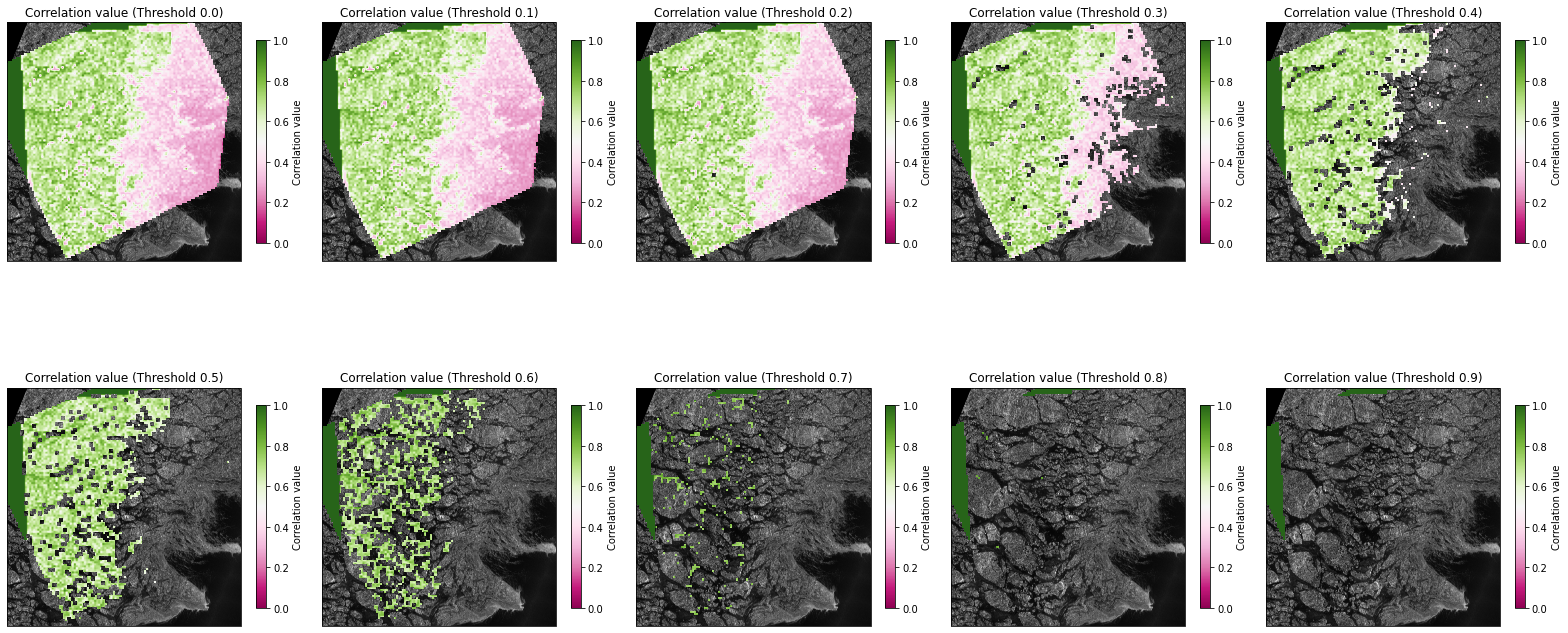

In [152]:
fig, axs = plt.subplots(nrows=2, ncols=5, figsize=(22, 11), subplot_kw={'projection': crs})
fig.subplots_adjust(hspace=0.5)  # Adjust vertical spacing between subplots

for i, ax in enumerate(axs.flat):
    if i < 10:  # Plot for the first 11 thresholds
        threshold = i * 0.1  # Generate threshold values from 0 to 1 with increments of 0.1
        gpi = (rpm > threshold)
        num_true_values = np.sum(gpi)
        #print(f"Number of True values in gpi for threshold {threshold}: {num_true_values}")

        # Filter out values of hpm less than the current threshold
        filtered_rpm = np.where(rpm > threshold, rpm, np.nan)
        ax.imshow(n1[1], cmap='gray', extent=[x1pm.min(), x1pm.max(), y1pm.min(), y1pm.max()], origin='upper')
        
        r_img = ax.imshow(filtered_rpm, extent=[x1pm.min(), x1pm.max(), y1pm.min(), y1pm.max()], origin='lower', cmap='PiYG', alpha=1, vmin=0, vmax=1)

        ax.set_title(f'Correlation value (Threshold {threshold:.1f})')
        ax.add_feature(land_50m, edgecolor='black')
        ax.set_xlim([x1pm.min() + 40000, x1pm.max() - 70000])
        ax.set_ylim([y1pm.min() + 30000, y1pm.max() - 60000])
        plt.colorbar(r_img, ax=ax, label='Correlation value', shrink=0.5)

plt.tight_layout()
plt.show()

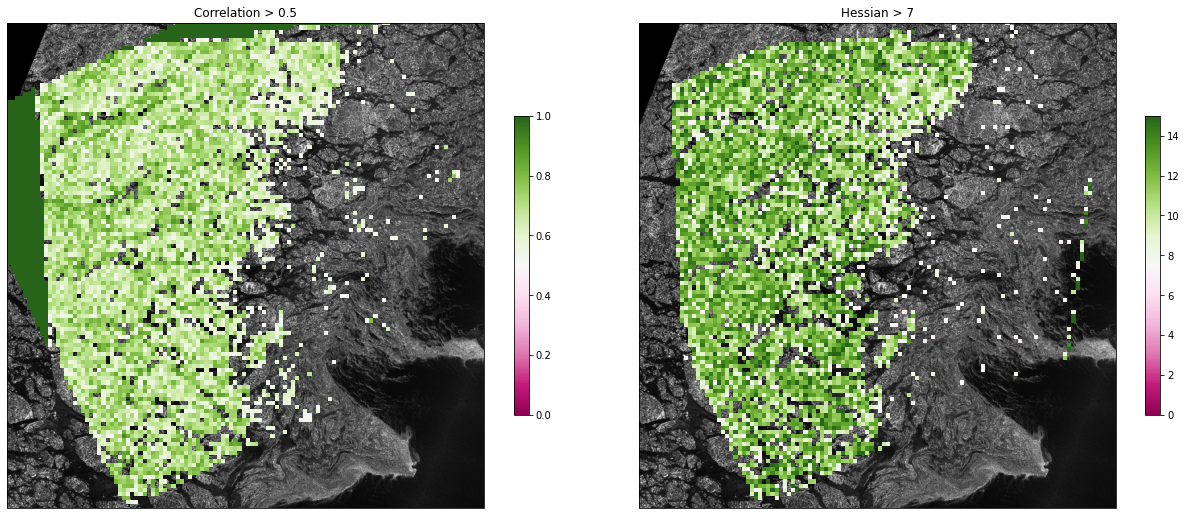

Number of True values after filtering with correlation : 6512
Number of True values after filtering with hessian : 4795


In [170]:
# spacial reference for plotting
crs = ccrs.LambertConformal(central_longitude=-25,
    central_latitude=77.5,
    false_easting=0.0,
    false_northing=0.0,
    secant_latitudes=None,
    standard_parallels=(77.5, 77.5),
    globe=None)

# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(22,11), subplot_kw={'projection': crs})

# Figure 1


ax1.imshow(n1[1], cmap='gray', extent=[x1pm.min(), x1pm.max(), y1pm.min(), y1pm.max()], origin='upper')

# Filter out values of rpm less than 0.5
filtered_rpm = np.where(rpm > 0.5, rpm, np.nan)

r_img = ax1.imshow(filtered_rpm, extent=[x1pm.min(), x1pm.max(), y1pm.min(), y1pm.max()], origin='lower', cmap='PiYG', alpha=1, vmin=0, vmax=1)
ax1.set_title('Correlation > 0.5')
ax1.add_feature(land_50m, edgecolor='black')
ax1.set_xlim([x1pm.min()+40000, x1pm.max()-70000])
ax1.set_ylim([y1pm.min()+30000, y1pm.max()-60000])
plt.colorbar(r_img, ax=ax1, shrink=0.5)

# Figure 2

ax2.imshow(n1[1], cmap='gray', extent=[x1pm.min(), x1pm.max(), y1pm.min(), y1pm.max()], origin='upper')

# Filter out values of hpm less than 7
filtered_hpm = np.where(hpm > 7, hpm, np.nan)
h_img = ax2.imshow(filtered_hpm, extent=[x1pm.min(), x1pm.max(), y1pm.min(), y1pm.max()], origin='lower', cmap='PiYG', alpha=1, vmin=0, vmax=15)
ax2.set_title('Hessian > 7')
ax2.add_feature(land_50m, edgecolor='black')
ax2.set_xlim([x1pm.min()+40000, x1pm.max()-70000])
ax2.set_ylim([y1pm.min()+30000, y1pm.max()-60000])
plt.colorbar(h_img, ax=ax2, shrink=0.5)

# Adjust the spacing between subplots
plt.subplots_adjust(wspace=0.06)  


#plt.tight_layout()
plt.show()

gpi = (rpm > 0.5) 
num_true_values = np.sum(gpi.data)
print(f"Number of True values after filtering with correlation : {num_true_values}")
gpi = (hpm > 7) 
num_true_values = np.sum(gpi.data)
print(f"Number of True values after filtering with hessian : {num_true_values}")


#### Applying hessian filter

In [19]:
# Import time difference between SAR1 and SAR2 from model_drift_export package 
%store -r total_time_diff
total_time_diff

88851

In [20]:
# model domain to reproject SAR image from 3996
model_d = Domain(srs, f'-te {min(X_subset.data)} {min(Y_subset.data)} {max(X_subset.data)} {max(Y_subset.data)} -tr 100 100')
# reproject n1 for visualizing SAR image in the same projection as model data
n1.reproject(model_d)

Number of True values without filtering : 9135
Number of True values after filtering with hessian : 4795


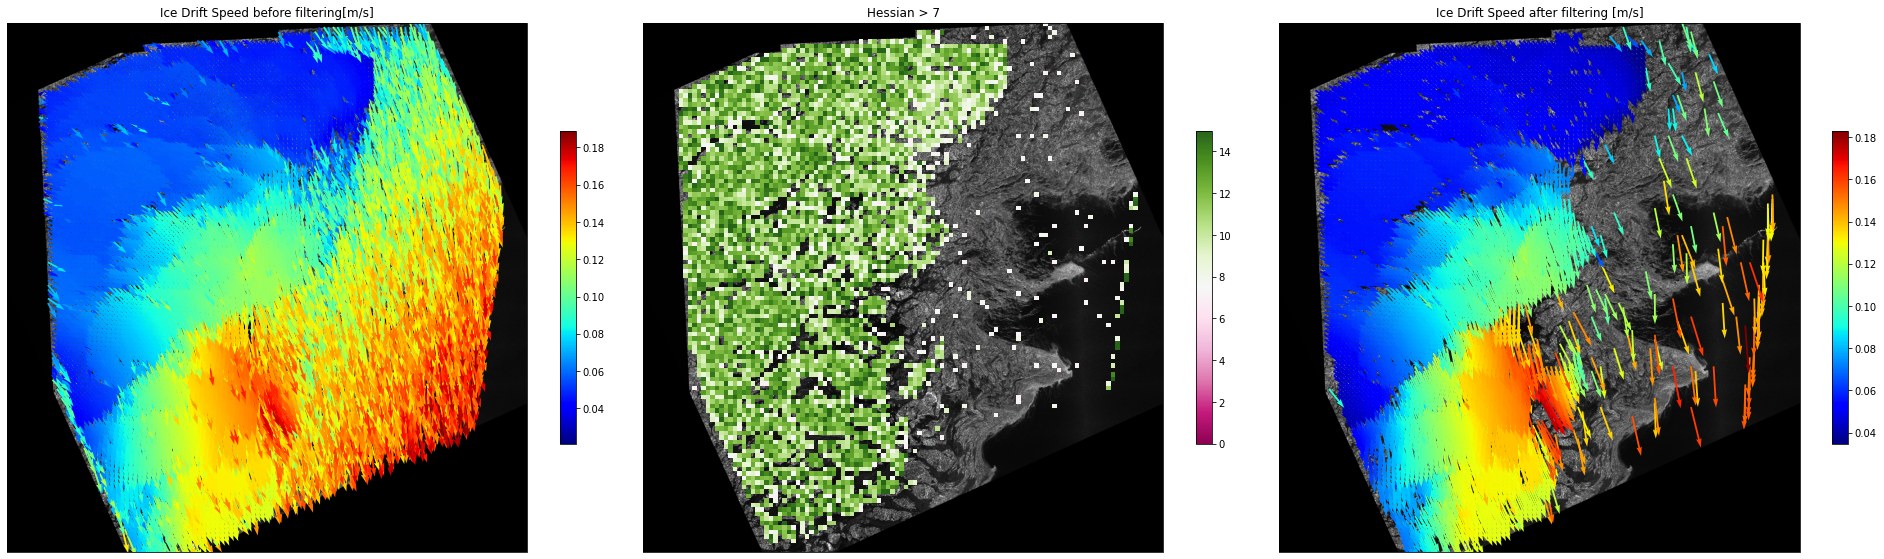

In [21]:
# Hessoan 7
dayssec = total_time_diff

# compute ice drift speed [m/s]
delta_t = dayssec #in seconds
u = upm / delta_t
v = vpm / delta_t
speed = np.sqrt((v**2+u**2)) 

# spacial reference for plotting
crs = ccrs.LambertConformal(central_longitude=-25,
    central_latitude=77.5,
    false_easting=0.0,
    false_northing=0.0,
    secant_latitudes=None,
    standard_parallels=(77.5, 77.5),
    globe=None)

# Create a figure with three subplots side by side
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(27,9), subplot_kw={'projection': crs})

# Figure 1

# filter vectors with hessian value
gpi = (hpm > 0) 
num_true_values = np.sum(gpi.data)
print(f"Number of True values without filtering : {num_true_values}")

# Plot the image on the first subplot
ax1.imshow(n1[1], cmap='gray', extent=[x1pm.min(), x1pm.max(), y1pm.min(), y1pm.max()], origin='upper')
#quiv1 = ax1.quiver(x1pm[gpi][::6], y1pm[gpi][::6], u[gpi][::6], v[gpi][::6], speed[gpi][::6], scale=2, cmap='jet', width=0.0035)
quiv1 = ax1.quiver(x1pm[gpi][::1], y1pm[gpi][::1], u[gpi][::1], v[gpi][::1], speed[gpi][::1], scale=2, cmap='jet', width=0.0035)
ax1.set_title('Ice Drift Speed before filtering[m/s]')
ax1.add_feature(land_50m, edgecolor='black')
ax1.set_xlim([x1pm.min()+40000, x1pm.max()-70000])
ax1.set_ylim([y1pm.min()+30000, y1pm.max()-60000])
plt.colorbar(quiv1, ax=ax1, orientation='vertical', shrink=0.5)

# Figure 2

ax2.imshow(n1[1], cmap='gray', extent=[x1pm.min(), x1pm.max(), y1pm.min(), y1pm.max()], origin='upper')

# Filter out values of hpm less than 7
filtered_hpm = np.where(hpm > 7, hpm, np.nan)
h_img = ax2.imshow(filtered_hpm, extent=[x1pm.min(), x1pm.max(), y1pm.min(), y1pm.max()], origin='lower', cmap='PiYG', alpha=1, vmin=0, vmax=15)
ax2.set_title('Hessian > 7')
ax2.add_feature(land_50m, edgecolor='black')
ax2.set_xlim([x1pm.min()+40000, x1pm.max()-70000])
ax2.set_ylim([y1pm.min()+30000, y1pm.max()-60000])
plt.colorbar(h_img, ax=ax2, shrink=0.5)

#Figure 3

# filter vectors with hessian value
gpi = (hpm > 7)
num_true_values = np.sum(gpi.data)
print(f"Number of True values after filtering with hessian : {num_true_values}")

#quiv1 = ax3.quiver(x1pm[gpi][::6], y1pm[gpi][::6], u[gpi][::6], v[gpi][::6], speed[gpi][::6], scale=2, cmap='jet', width=0.0035)
quiv1 = ax3.quiver(x1pm[gpi][::1], y1pm[gpi][::1], u[gpi][::1], v[gpi][::1], speed[gpi][::1], scale=2, cmap='jet', width=0.0035)
ax3.imshow(n1[1], cmap='gray', extent=[x1pm.min(), x1pm.max(), y1pm.min(), y1pm.max()], origin='upper')
ax3.set_title('Ice Drift Speed after filtering [m/s]')
ax3.add_feature(land_50m, edgecolor='black')
ax3.set_xlim([x1pm.min()+40000, x1pm.max()-70000])
ax3.set_ylim([y1pm.min()+30000, y1pm.max()-60000])
plt.colorbar(quiv1, ax=ax3, orientation='vertical', shrink=0.5)



plt.tight_layout()
plt.show()


Number of True values without filtering : 9135
Number of True values after filtering with hessian : 4064


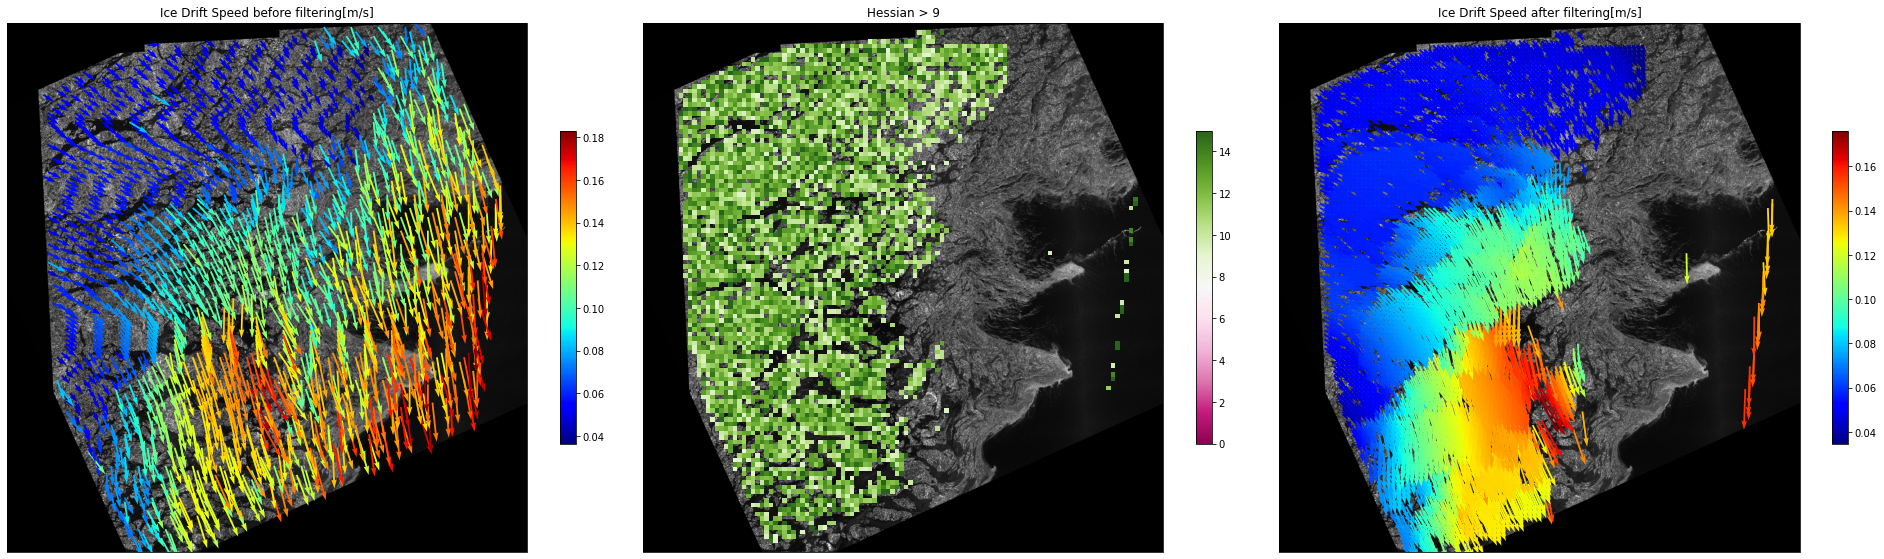

In [22]:
# Hessoan 9

dayssec = total_time_diff

# compute ice drift speed [m/s]
delta_t = dayssec #in seconds
u = upm / delta_t
v = vpm / delta_t
speed = np.sqrt((v**2+u**2)) 

# spacial reference for plotting
crs = ccrs.LambertConformal(central_longitude=-25,
    central_latitude=77.5,
    false_easting=0.0,
    false_northing=0.0,
    secant_latitudes=None,
    standard_parallels=(77.5, 77.5),
    globe=None)

# Create a figure with three subplots side by side
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(27,9), subplot_kw={'projection': crs})

# Figure 1

# filter vectors with hessian value
gpi = (hpm > 0) 
num_true_values = np.sum(gpi.data)
print(f"Number of True values without filtering : {num_true_values}")

# Plot the image on the first subplot
ax1.imshow(n1[1], cmap='gray', extent=[x1pm.min(), x1pm.max(), y1pm.min(), y1pm.max()], origin='upper')
quiv1 = ax1.quiver(x1pm[gpi][::6], y1pm[gpi][::6], u[gpi][::6], v[gpi][::6], speed[gpi][::6], scale=2, cmap='jet', width=0.0035)
#quiv1 = ax1.quiver(x1pm[gpi][::1], y1pm[gpi][::1], u[gpi][::1], v[gpi][::1], speed[gpi][::1], scale=2, cmap='jet', width=0.0035)
ax1.set_title('Ice Drift Speed before filtering[m/s]')
ax1.add_feature(land_50m, edgecolor='black')
ax1.set_xlim([x1pm.min()+40000, x1pm.max()-70000])
ax1.set_ylim([y1pm.min()+30000, y1pm.max()-60000])
plt.colorbar(quiv1, ax=ax1, orientation='vertical', shrink=0.5)

# Figure 2

ax2.imshow(n1[1], cmap='gray', extent=[x1pm.min(), x1pm.max(), y1pm.min(), y1pm.max()], origin='upper')

# Filter out values of hpm 
filtered_hpm = np.where(hpm > 9, hpm, np.nan)
h_img = ax2.imshow(filtered_hpm, extent=[x1pm.min(), x1pm.max(), y1pm.min(), y1pm.max()], origin='lower', cmap='PiYG', alpha=1, vmin=0, vmax=15)
ax2.set_title('Hessian > 9')
ax2.add_feature(land_50m, edgecolor='black')
ax2.set_xlim([x1pm.min()+40000, x1pm.max()-70000])
ax2.set_ylim([y1pm.min()+30000, y1pm.max()-60000])
plt.colorbar(h_img, ax=ax2, shrink=0.5)

#Figure 3

# filter vectors with hessian value
gpi = (hpm > 9)
num_true_values = np.sum(gpi.data)
print(f"Number of True values after filtering with hessian : {num_true_values}")

#quiv1 = ax3.quiver(x1pm[gpi][::6], y1pm[gpi][::6], u[gpi][::6], v[gpi][::6], speed[gpi][::6], scale=2, cmap='jet', width=0.0035)
quiv1 = ax3.quiver(x1pm[gpi][::1], y1pm[gpi][::1], u[gpi][::1], v[gpi][::1], speed[gpi][::1], scale=2, cmap='jet', width=0.0035)
ax3.imshow(n1[1], cmap='gray', extent=[x1pm.min(), x1pm.max(), y1pm.min(), y1pm.max()], origin='upper')
ax3.set_title('Ice Drift Speed after filtering[m/s]')
ax3.add_feature(land_50m, edgecolor='black')
ax3.set_xlim([x1pm.min()+40000, x1pm.max()-70000])
ax3.set_ylim([y1pm.min()+30000, y1pm.max()-60000])
plt.colorbar(quiv1, ax=ax3, orientation='vertical', shrink=0.5)



plt.tight_layout()
plt.show()


#### Applying concentration filter (with picked hessian 9)

Check and change concentration to 24 end mean one

In [23]:
# Use model concentration to filter out water values
# Export time_period variable form model_drift_export notebook 
%store -r time_period

# Export concentration variable
siconc = data['ice_concentration'] # ice area  (aggregate)

# Concentration at the start of the time period is used as it is corresponding to the situation where vector starts from
siconc_subset  = siconc.sel(time=time_period[0], ensemble_member = 8)[min(r):max(r)+1, min(c):max(c)+1].fillna(np.nan)

# Save subset concentration variable
%store siconc_subset

Stored 'siconc_subset' (DataArray)


Number of True values in gpi before filtering: 4064
Number of True values in gpi after filtering: 4043


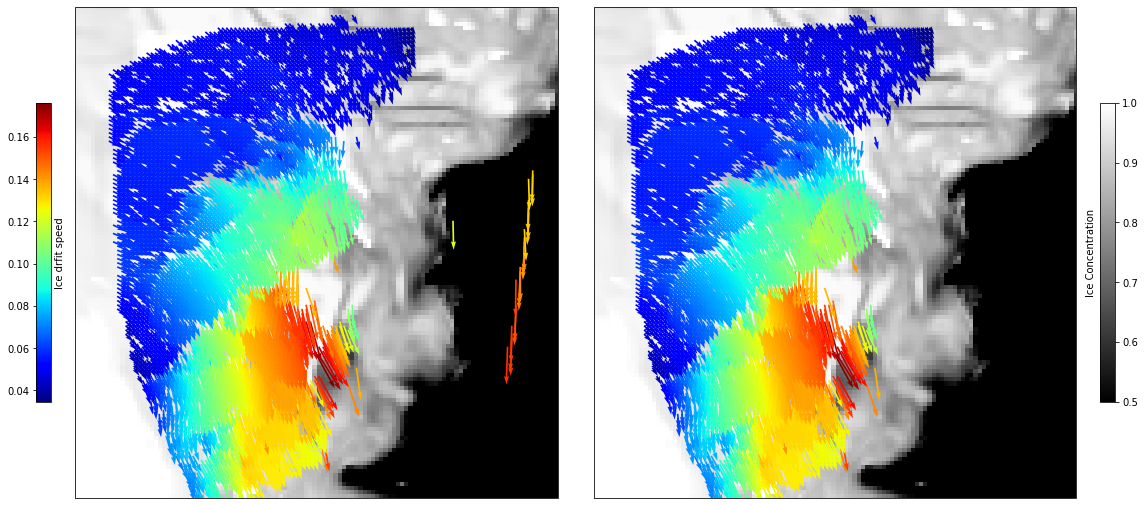

In [24]:
# without steps for visualizing 
dayssec = total_time_diff

# compute ice drift speed [m/s]
delta_t = dayssec #in seconds
u = upm / delta_t
v = vpm / delta_t
speed = np.sqrt((v**2+u**2)) 

# spacial reference for plotting
crs = ccrs.LambertConformal(central_longitude=-25,
    central_latitude=77.5,
    false_easting=0.0,
    false_northing=0.0,
    secant_latitudes=None,
    standard_parallels=(77.5, 77.5),
    globe=None)

# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(22,11), subplot_kw={'projection': crs})

# Figure 1

# filter vectors with hessian value
gpi = (hpm > 9)
num_true_values = np.sum(gpi.data)
print(f"Number of True values in gpi before filtering: {num_true_values}")
# plot concentration
conc_img = ax1.imshow(siconc_subset, extent=[x1pm.min(), x1pm.max(), y1pm.min(), y1pm.max()], origin='lower', cmap='gray', alpha=1, vmin=0.5, vmax=1)
# plot every n_th vector
#quiv=ax1.quiver(x1pm[gpi][::6], y1pm[gpi][::6], u[gpi][::6], v[gpi][::6],speed[gpi][::6], scale=2, cmap='jet',width=0.0035)
quiv=ax1.quiver(x1pm[gpi][::1], y1pm[gpi][::1], u[gpi][::1], v[gpi][::1],speed[gpi][::1], scale=2, cmap='jet',width=0.0035) 
plt.quiverkey(quiv, 110000, -770000, 0.05, '0.05 m/s', coordinates='data')
#plt.title('Ice drfit speed [m/s]')
ax1.add_feature(land_50m, edgecolor='black')
ax1.set_xlim([x1pm.min()+40000, x1pm.max()-70000])
ax1.set_ylim([y1pm.min()+30000, y1pm.max()-60000])

#  Figure 2

# filter vectors with hessian value and concentration
gpi = (hpm > 9)*(siconc_subset > 0.5)
num_true_values = np.sum(gpi.data)
print(f"Number of True values in gpi after filtering: {num_true_values}")
# plot concentration
conc_img = ax2.imshow(siconc_subset, extent=[x1pm.min(), x1pm.max(), y1pm.min(), y1pm.max()], origin='lower', cmap='gray', alpha=1, vmin=0.5, vmax=1)
#plot every n_th vector
#quiv=ax2.quiver(x1pm[gpi][::6], y1pm[gpi][::6], u[gpi][::6], v[gpi][::6],speed[gpi][::6], scale=2, cmap='jet',width=0.0035)
quiv=ax2.quiver(x1pm[gpi][::1], y1pm[gpi][::1], u[gpi][::1], v[gpi][::1],speed[gpi][::1], scale=2, cmap='jet',width=0.0035) 
cbar1 = plt.colorbar(quiv,ax=ax1, label='Ice drfit speed', location='left', shrink=0.5, pad=0.04)
cbar1.ax.yaxis.set_label_position('right')
plt.quiverkey(quiv, 110000, -770000, 0.05, '0.05 m/s', coordinates='data')
#plt.title('Ice drfit speed [m/s]')
ax2.add_feature(land_50m, edgecolor='black')
ax2.set_xlim([x1pm.min()+40000, x1pm.max()-70000])
ax2.set_ylim([y1pm.min()+30000, y1pm.max()-60000])
# colorbar for the concentration
cbar2 = plt.colorbar(conc_img, ax=ax2, label='Ice Concentration', location='right', shrink=0.5, pad=0.04)
cbar2.ax.yaxis.set_label_position('left')

# Adjust the spacing between subplots
plt.subplots_adjust(wspace=0.06)  


#plt.tight_layout()
plt.show()



Number of True values in gpi before filtering: 4064
Number of True values in gpi after filtering: 4043


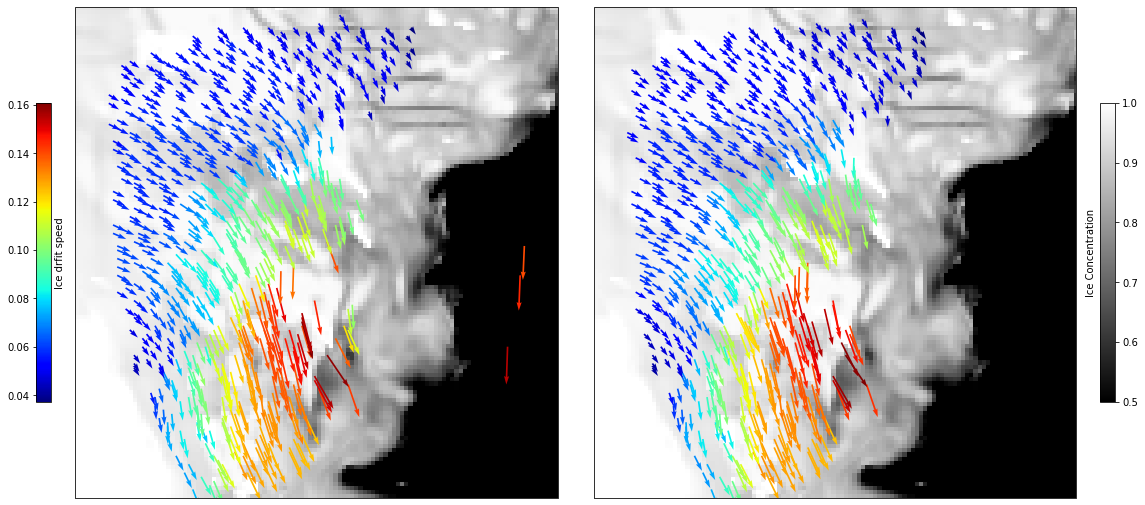

In [25]:
# With visualizing every 6th pixel
dayssec = total_time_diff

# compute ice drift speed [m/s]
delta_t = dayssec #in seconds
u = upm / delta_t
v = vpm / delta_t
speed = np.sqrt((v**2+u**2)) 

# spacial reference for plotting
crs = ccrs.LambertConformal(central_longitude=-25,
    central_latitude=77.5,
    false_easting=0.0,
    false_northing=0.0,
    secant_latitudes=None,
    standard_parallels=(77.5, 77.5),
    globe=None)

# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(22,11), subplot_kw={'projection': crs})

# Figure 1

# filter vectors with hessian value
gpi = (hpm > 9)
num_true_values = np.sum(gpi.data)
print(f"Number of True values in gpi before filtering: {num_true_values}")
# plot concentration
conc_img = ax1.imshow(siconc_subset, extent=[x1pm.min(), x1pm.max(), y1pm.min(), y1pm.max()], origin='lower', cmap='gray', alpha=1, vmin=0.5, vmax=1)
# plot every n_th vector
quiv=ax1.quiver(x1pm[gpi][::6], y1pm[gpi][::6], u[gpi][::6], v[gpi][::6],speed[gpi][::6], scale=2, cmap='jet',width=0.0035)
#quiv=ax1.quiver(x1pm[gpi][::1], y1pm[gpi][::1], u[gpi][::1], v[gpi][::1],speed[gpi][::1], scale=2, cmap='jet',width=0.0035) 
plt.quiverkey(quiv, 110000, -770000, 0.05, '0.05 m/s', coordinates='data')
#plt.title('Ice drfit speed [m/s]')
ax1.add_feature(land_50m, edgecolor='black')
ax1.set_xlim([x1pm.min()+40000, x1pm.max()-70000])
ax1.set_ylim([y1pm.min()+30000, y1pm.max()-60000])

#  Figure 2

# filter vectors with hessian value and concentration
gpi = (hpm > 9)*(siconc_subset > 0.5)
num_true_values = np.sum(gpi.data)
print(f"Number of True values in gpi after filtering: {num_true_values}")
# plot concentration
conc_img = ax2.imshow(siconc_subset, extent=[x1pm.min(), x1pm.max(), y1pm.min(), y1pm.max()], origin='lower', cmap='gray', alpha=1, vmin=0.5, vmax=1)
#plot every n_th vector
quiv=ax2.quiver(x1pm[gpi][::6], y1pm[gpi][::6], u[gpi][::6], v[gpi][::6],speed[gpi][::6], scale=2, cmap='jet',width=0.0035)
#quiv=ax2.quiver(x1pm[gpi][::1], y1pm[gpi][::1], u[gpi][::1], v[gpi][::1],speed[gpi][::1], scale=2, cmap='jet',width=0.0035) 
cbar1 = plt.colorbar(quiv,ax=ax1, label='Ice drfit speed', location='left', shrink=0.5, pad=0.04)
cbar1.ax.yaxis.set_label_position('right')
plt.quiverkey(quiv, 110000, -770000, 0.05, '0.05 m/s', coordinates='data')
#plt.title('Ice drfit speed [m/s]')
ax2.add_feature(land_50m, edgecolor='black')
ax2.set_xlim([x1pm.min()+40000, x1pm.max()-70000])
ax2.set_ylim([y1pm.min()+30000, y1pm.max()-60000])
# colorbar for the concentration
cbar2 = plt.colorbar(conc_img, ax=ax2, label='Ice Concentration', location='right', shrink=0.5, pad=0.04)
cbar2.ax.yaxis.set_label_position('left')

# Adjust the spacing between subplots
plt.subplots_adjust(wspace=0.06)  


#plt.tight_layout()
plt.show()



#### Comparing with model drift
go to drift_comparison.ipynb


In [272]:
%store upm
%store vpm
%store apm
%store rpm
%store hpm
%store lon2pm
%store lat2pm
%store lon1pm
%store lat1pm

Stored 'upm' (ndarray)
Stored 'vpm' (ndarray)
Stored 'apm' (ndarray)
Stored 'rpm' (ndarray)
Stored 'hpm' (ndarray)
Stored 'lon2pm' (ndarray)
Stored 'lat2pm' (ndarray)
Stored 'lon1pm' (ndarray)
Stored 'lat1pm' (ndarray)


#### Comparison -> old cells, now comaprison is another notebook

##### Importing model drift data 

In [197]:
cum_drift_path = r'/home/jovyan/data/model_data_process_output/for_comparison_lambert/total_model_displacement_20221119T07-20221120T09.csv'

In [198]:
with open(cum_drift_path) as csvfile:
    csvreader = csv.reader(csvfile)
    # check if the file has a header row
    has_header = csv.Sniffer().has_header(csvfile.read(1024))
    csvfile.seek(0)  # reset file pointer
    #skip header row if it exists
    if has_header:
        next(csvreader)
    displacements = np.array([row for row in csvreader]).astype(float)

In [208]:
lon_mod, lat_mod = displacements[:, [0]] , displacements[:, [1]] 
dx_mod, dy_mod = displacements[:, [2]] , displacements[:, [3]] 
print( lon_mod.shape, lat_mod.shape,dx_mod.shape, dy_mod.shape ),

dx_mod = dx_mod.reshape(upm.shape)
dy_mod = dy_mod.reshape(upm.shape) 
print(dx_mod.shape, dy_mod.shape)


(24640, 1) (24640, 1) (24640, 1) (24640, 1)
(154, 160) (154, 160)


##### Visualizing 

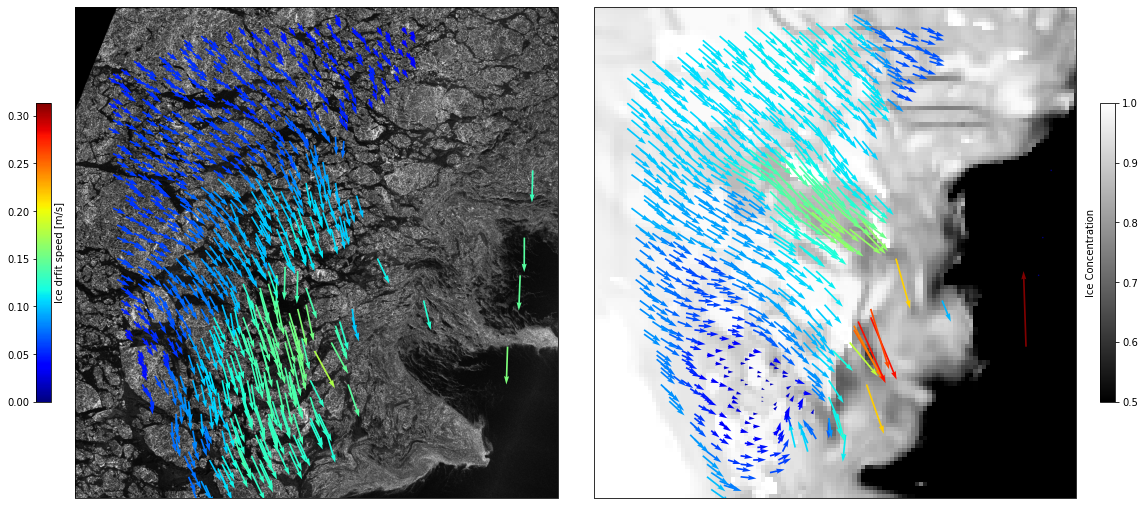

In [257]:
#dayssec = 24*60*60
dayssec = total_time_diff

# compute ice drift speed [m/s]
delta_t = dayssec #in seconds
u = upm / delta_t
v = vpm / delta_t
speed = np.sqrt((v**2+u**2)) 
# compute model ice drift speed [m/s]
delta_t = dayssec #in seconds
u_model = dx_mod / delta_t
v_model = dy_mod / delta_t
speed_model = np.sqrt((v_model**2+u_model**2)) 

gpi = (hpm > 8)

# Combined data range
all_speeds = np.concatenate([speed[gpi], speed_model[gpi]])
vmin, vmax = np.min(all_speeds), np.max(all_speeds)
# Use this range to normalize both datasets
norm = Normalize(vmin=vmin, vmax=vmax)
#norm = Normalize(vmin=vmin, vmax=0.2)

# spacial reference for plotting
crs = ccrs.LambertConformal(central_longitude=-25,
    central_latitude=77.5,
    false_easting=0.0,
    false_northing=0.0,
    secant_latitudes=None,
    standard_parallels=(77.5, 77.5),
    globe=None)

# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(22,11), subplot_kw={'projection': crs})

# Figure 1

ax1.imshow(n1[1], cmap='gray', extent=[x1pm.min(), x1pm.max(), y1pm.min(), y1pm.max()], origin='upper')
# Overlay a semi-transparent gray layer
#gray_value = 0.9 # Midway between 0 (black) and 1 (white)
#rect = Rectangle((x1pm.min(), y1pm.min()), x1pm.max() - x1pm.min(), y1pm.max() - y1pm.min(), facecolor='black', alpha=0.4) #facecolor = str(gray_value)
#ax1.add_patch(rect)

# plot every n_th vector
quiv1=ax1.quiver(x1pm[gpi][::6], y1pm[gpi][::6], u[gpi][::6], v[gpi][::6],speed[gpi][::6], scale=2, cmap='jet',width=0.0035, norm = norm)
#quiv1=ax1.quiver(x1pm[gpi][::1], y1pm[gpi][::1], u[gpi][::1], v[gpi][::1],speed[gpi][::1], scale=2, cmap='jet',width=0.0035,  norm = norm) 
#quiv1=ax1.quiver(x1pm[::1], y1pm[::1], u[::1], v[::1],speed[::1], scale=2, cmap='jet',width=0.0035,  norm = norm) 
plt.quiverkey(quiv, 110000, -770000, 0.05, '0.05 m/s', coordinates='data')
#plt.title('Ice drfit speed [m/s]')
ax1.add_feature(land_50m, edgecolor='black')
ax1.set_xlim([x1pm.min()+40000, x1pm.max()-70000])
ax1.set_ylim([y1pm.min()+30000, y1pm.max()-60000])

#  Figure 2

# plot concentration
conc_img = ax2.imshow(siconc_subset, extent=[x1pm.min(), x1pm.max(), y1pm.min(), y1pm.max()], origin='lower', cmap='gray', alpha=1, vmin=0.5, vmax=1)
#plot every n_th vector
quiv2 = ax2.quiver(x1pm[gpi][::6], y1pm[gpi][::6], u_model[gpi][::6], v_model[gpi][::6], speed_model[gpi][::6], scale=2, cmap='jet', width=0.0035, norm=norm)
#quiv2 = ax2.quiver(x1pm[gpi][::1], y1pm[gpi][::1], u_model[gpi][::1], v_model[gpi][::1], speed_model[gpi][::1], scale=2, cmap='jet', width=0.0035, norm=norm)
#quiv2 = ax2.quiver(x1pm[::1], y1pm[::1], u_model[::1], v_model[::1], speed_model[::1], scale=2, cmap='jet', width=0.0035, norm=norm)
plt.quiverkey(quiv, 110000, -770000, 0.05, '0.05 m/s', coordinates='data')
#plt.title('Ice drfit speed [m/s]')
ax2.add_feature(land_50m, edgecolor='black')
ax2.set_xlim([x1pm.min()+40000, x1pm.max()-70000])
ax2.set_ylim([y1pm.min()+30000, y1pm.max()-60000])
# colorbar for the concentration



#plt.colorbar(quiv1, ax=ax1, orientation='vertical', shrink=0.5)
cbar1 = plt.colorbar(quiv1,ax=ax1, label='Ice drfit speed [m/s]', location='left', shrink=0.5, pad=0.04)
cbar1.ax.yaxis.set_label_position('right')

cbar2 = plt.colorbar(conc_img, ax=ax2, label='Ice Concentration', location='right', shrink=0.5, pad=0.04)
cbar2.ax.yaxis.set_label_position('left')

# Adjust the spacing between subplots
plt.subplots_adjust(wspace=0.06)  


#plt.tight_layout()
plt.show()



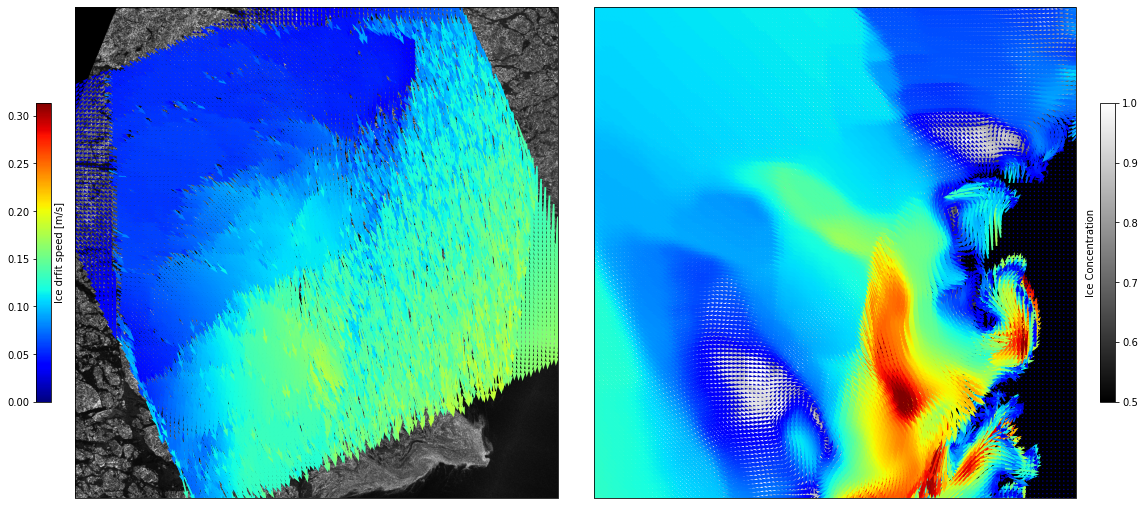

In [222]:
#dayssec = 24*60*60
dayssec = total_time_diff

# compute ice drift speed [m/s]
delta_t = dayssec #in seconds
u = upm / delta_t
v = vpm / delta_t
speed = np.sqrt((v**2+u**2)) 
# compute model ice drift speed [m/s]
delta_t = dayssec #in seconds
u_model = dx_mod / delta_t
v_model = dy_mod / delta_t
speed_model = np.sqrt((v_model**2+u_model**2)) 



# spacial reference for plotting
crs = ccrs.LambertConformal(central_longitude=-25,
    central_latitude=77.5,
    false_easting=0.0,
    false_northing=0.0,
    secant_latitudes=None,
    standard_parallels=(77.5, 77.5),
    globe=None)

# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(22,11), subplot_kw={'projection': crs})

# Figure 1

ax1.imshow(n1[1], cmap='gray', extent=[x1pm.min(), x1pm.max(), y1pm.min(), y1pm.max()], origin='upper')
# Overlay a semi-transparent gray layer
#gray_value = 0.9 # Midway between 0 (black) and 1 (white)
#rect = Rectangle((x1pm.min(), y1pm.min()), x1pm.max() - x1pm.min(), y1pm.max() - y1pm.min(), facecolor='black', alpha=0.4) #facecolor = str(gray_value)
#ax1.add_patch(rect)

# plot every n_th vector
#quiv1=ax1.quiver(x1pm[gpi][::6], y1pm[gpi][::6], u[gpi][::6], v[gpi][::6],speed[gpi][::6], scale=2, cmap='jet',width=0.0035, norm = norm)
#quiv1=ax1.quiver(x1pm[gpi][::1], y1pm[gpi][::1], u[gpi][::1], v[gpi][::1],speed[gpi][::1], scale=2, cmap='jet',width=0.0035,  norm = norm) 
quiv1=ax1.quiver(x1pm[::1], y1pm[::1], u[::1], v[::1],speed[::1], scale=2, cmap='jet',width=0.0035,  norm = norm) 
plt.quiverkey(quiv, 110000, -770000, 0.05, '0.05 m/s', coordinates='data')
#plt.title('Ice drfit speed [m/s]')
ax1.add_feature(land_50m, edgecolor='black')
ax1.set_xlim([x1pm.min()+40000, x1pm.max()-70000])
ax1.set_ylim([y1pm.min()+30000, y1pm.max()-60000])

#  Figure 2

# plot concentration
conc_img = ax2.imshow(siconc_subset, extent=[x1pm.min(), x1pm.max(), y1pm.min(), y1pm.max()], origin='lower', cmap='gray', alpha=1, vmin=0.5, vmax=1)
#plot every n_th vector
#quiv2 = ax2.quiver(x1pm[gpi][::6], y1pm[gpi][::6], u_model[gpi][::6], v_model[gpi][::6], speed_model[gpi][::6], scale=2, cmap='jet', width=0.0035, norm=norm)
#quiv2 = ax2.quiver(x1pm[gpi][::1], y1pm[gpi][::1], u_model[gpi][::1], v_model[gpi][::1], speed_model[gpi][::1], scale=2, cmap='jet', width=0.0035, norm=norm)
quiv2 = ax2.quiver(x1pm[::1], y1pm[::1], u_model[::1], v_model[::1], speed_model[::1], scale=2, cmap='jet', width=0.0035, norm=norm)
plt.quiverkey(quiv, 110000, -770000, 0.05, '0.05 m/s', coordinates='data')
#plt.title('Ice drfit speed [m/s]')
ax2.add_feature(land_50m, edgecolor='black')
ax2.set_xlim([x1pm.min()+40000, x1pm.max()-70000])
ax2.set_ylim([y1pm.min()+30000, y1pm.max()-60000])
# colorbar for the concentration


# Combined data range
all_speeds = np.concatenate([speed[gpi], speed_model[gpi]])
vmin, vmax = np.min(all_speeds), np.max(all_speeds)
# Use this range to normalize both datasets
norm = Normalize(vmin=vmin, vmax=vmax)

#plt.colorbar(quiv1, ax=ax1, orientation='vertical', shrink=0.5)
cbar1 = plt.colorbar(quiv1,ax=ax1, label='Ice drfit speed [m/s]', location='left', shrink=0.5, pad=0.04)
cbar1.ax.yaxis.set_label_position('right')

cbar2 = plt.colorbar(conc_img, ax=ax2, label='Ice Concentration', location='right', shrink=0.5, pad=0.04)
cbar2.ax.yaxis.set_label_position('left')

# Adjust the spacing between subplots
plt.subplots_adjust(wspace=0.06)  


#plt.tight_layout()
plt.show()



##### Calculting error

In [255]:
ref_displacement = np.sqrt((upm**2+vpm**2))
model_displacement =  np.sqrt((dx_mod**2+dy_mod**2))

In [126]:
rmse = np.sqrt(np.nanmean((ref_displacement - model_displacement)**2))
rmse

6093.524475966157

In [259]:
# Calculate RMSE
rmse = np.sqrt(np.nanmean((ref_displacement - model_displacement) ** 2))

# Calculate average of reference data (arr1)
average_ref_displacement = np.nanmean(ref_displacement)

# Calculate Relative RMSE in percentage
relative_rmse = (rmse / average_ref_displacement) * 100

print(f"Relative RMSE: {relative_rmse:.2f}%")

Relative RMSE: 74.41%


In [260]:
# Root Mean Square Error
rmse = np.sqrt(np.nanmean((upm - dx_mod)**2))

# Absolute Error 
abs_error_dx = (upm - dx_mod)
abs_error_dy = (vpm - dy_mod)

# Relative Error (check for zeroes)
relative_error_dx = (upm - dx_mod)/upm
relative_error_dy = (vpm - dy_mod)/upm

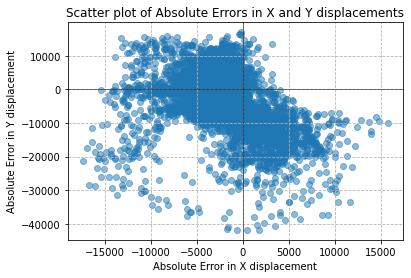

In [261]:
import matplotlib.pyplot as plt

plt.scatter(abs_error_dx, abs_error_dy, alpha=0.5)
plt.xlabel('Absolute Error in X displacement')
plt.ylabel('Absolute Error in Y displacement')
plt.title('Scatter plot of Absolute Errors in X and Y displacements')
plt.axhline(0, color='black',linewidth=0.5)
plt.axvline(0, color='black',linewidth=0.5)
plt.grid(True, which="both", ls="--", c='0.7')
plt.show()

In [263]:
delta_t = total_time_diff #in seconds
u = dx_mod / delta_t
v = dy_mod / delta_t
speed_model = np.sqrt((v**2+u**2)) 

# compute ice drift ERROR speed [m/s]
delta_t = total_time_diff #in seconds
u = upm / delta_t
v = vpm / delta_t
speed_ref = np.sqrt((v**2+u**2)) 

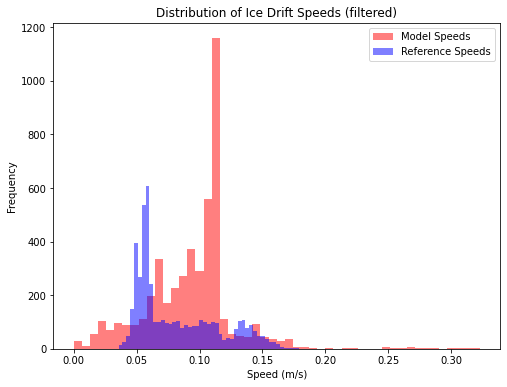

Reference Speeds:
Mean speed: 0.0816 m/s
Min speed: 0.0357 m/s
Max speed: 0.1884 m/s
95th percentile speed: 0.1443 m/s

Model Speeds:
Mean speed: 0.0939 m/s
Min speed: 0.0000 m/s
Max speed: 0.3225 m/s
95th percentile speed: 0.1451 m/s


In [264]:
plt.figure(figsize=(8,6))


# Plotting Model Speed
plt.hist(speed_model[gpi], bins=50, color='red', alpha=0.5, label='Model Speeds')

# Plotting Reference Speed
plt.hist(speed_ref[gpi], bins=50, color='blue', alpha=0.5, label='Reference Speeds')

plt.xlabel('Speed (m/s)')
plt.ylabel('Frequency')
plt.title('Distribution of Ice Drift Speeds (filtered)')
plt.legend()
plt.show()

# Print statistics for reference speeds
percentile_95_ref = np.percentile(speed_ref[gpi], 95)
mean_speed_ref = np.nanmean(speed_ref[gpi])
min_speed_ref = np.nanmin(speed_ref[gpi])
max_speed_ref = np.nanmax(speed_ref[gpi])

print(f"Reference Speeds:")
print(f"Mean speed: {mean_speed_ref:.4f} m/s")
print(f"Min speed: {min_speed_ref:.4f} m/s")
print(f"Max speed: {max_speed_ref:.4f} m/s")
print(f"95th percentile speed: {percentile_95_ref:.4f} m/s")

# Print statistics for model speeds
percentile_95_model = np.percentile(speed_model[gpi], 95)
mean_speed_model = np.nanmean(speed_model[gpi])
min_speed_model = np.nanmin(speed_model[gpi])
max_speed_model = np.nanmax(speed_model[gpi])

print("\nModel Speeds:")
print(f"Mean speed: {mean_speed_model:.4f} m/s")
print(f"Min speed: {min_speed_model:.4f} m/s")
print(f"Max speed: {max_speed_model:.4f} m/s")
print(f"95th percentile speed: {percentile_95_model:.4f} m/s")


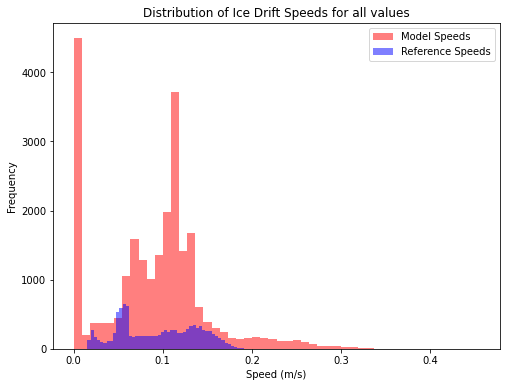

Reference Speeds:
Mean speed: 0.0816 m/s
Min speed: 0.0357 m/s
Max speed: 0.1884 m/s
95th percentile speed: 0.1443 m/s

Model Speeds:
Mean speed: 0.0939 m/s
Min speed: 0.0000 m/s
Max speed: 0.3225 m/s
95th percentile speed: 0.1451 m/s


In [265]:
#for all values
plt.figure(figsize=(8,6))


# Plotting Model Speed
plt.hist(speed_model.flatten(), bins=50, color='red', alpha=0.5, label='Model Speeds')

# Plotting Reference Speed
plt.hist(speed_ref.flatten(), bins=50, color='blue', alpha=0.5, label='Reference Speeds')

plt.xlabel('Speed (m/s)')
plt.ylabel('Frequency')
plt.title('Distribution of Ice Drift Speeds for all values')
plt.legend()
plt.show()

# Print statistics for reference speeds
percentile_95_ref = np.percentile(speed_ref[gpi], 95)
mean_speed_ref = np.nanmean(speed_ref[gpi])
min_speed_ref = np.nanmin(speed_ref[gpi])
max_speed_ref = np.nanmax(speed_ref[gpi])

print(f"Reference Speeds:")
print(f"Mean speed: {mean_speed_ref:.4f} m/s")
print(f"Min speed: {min_speed_ref:.4f} m/s")
print(f"Max speed: {max_speed_ref:.4f} m/s")
print(f"95th percentile speed: {percentile_95_ref:.4f} m/s")

# Print statistics for model speeds
percentile_95_model = np.percentile(speed_model[gpi], 95)
mean_speed_model = np.nanmean(speed_model[gpi])
min_speed_model = np.nanmin(speed_model[gpi])
max_speed_model = np.nanmax(speed_model[gpi])

print("\nModel Speeds:")
print(f"Mean speed: {mean_speed_model:.4f} m/s")
print(f"Min speed: {min_speed_model:.4f} m/s")
print(f"Max speed: {max_speed_model:.4f} m/s")
print(f"95th percentile speed: {percentile_95_model:.4f} m/s")


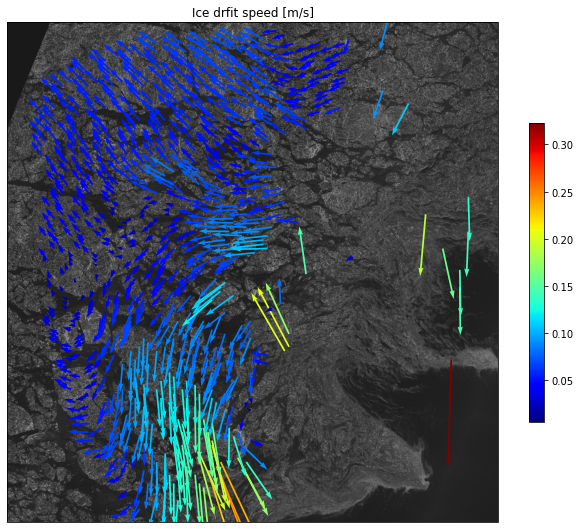

In [266]:
from matplotlib.patches import Rectangle

dayssec = 24*60*60

# compute ice drift speed [m/s]
delta_t = dayssec #in seconds
u = abs_error_dx / delta_t
v = abs_error_dy / delta_t
speed = np.sqrt((v**2+u**2)) 


# plot valid vectors in Polar stereographic projection
gpi = (hpm > 7) 
# X/Y grids in polar stereographic projection covering image_1
#x1pm, y1pm = dom_pm.get_geolocation_grids(dst_srs=srs)
#x1pm, y1pm = d.get_geolocation_grids(pm_step, dst_srs=srs)


# spacial reference for plotting
crs = ccrs.LambertConformal(central_longitude=-25,
    central_latitude=77.5,
    false_easting=0.0,
    false_northing=0.0,
    secant_latitudes=None,
    standard_parallels=(77.5, 77.5),
    globe=None)


plt.figure(figsize=(11,11))
ax = plt.axes(projection=crs)


ax.imshow(n1[1], cmap='gray', extent=[x1pm.min(), x1pm.max(), y1pm.min(), y1pm.max()], origin='upper') 
# Overlay a semi-transparent gray layer
gray_value = 0.2 # Midway between 0 (black) and 1 (white)
rect = Rectangle((x1pm.min(), y1pm.min()), x1pm.max() - x1pm.min(), y1pm.max() - y1pm.min(), facecolor=str(gray_value), alpha=0.5)
ax.add_patch(rect)
#plot every n_th vector
quiv=ax.quiver(x1pm[gpi][::6], y1pm[gpi][::6], u[gpi][::6], v[gpi][::6],speed[gpi][::6], scale=1.5, cmap='jet',width=0.0035) #, 
plt.colorbar(quiv, shrink=0.5)
plt.quiverkey(quiv, 110000, -770000, 0.05, '0.05 m/s', coordinates='data')
plt.title('Ice drfit speed [m/s]')
ax.add_feature(land_50m, edgecolor='black')
ax.set_xticks([-300000, -100000, 0, 100000, 300000])
ax.set_yticks([-700000, -500000, -300000])

#ax.set_xlim([x1pm.min(), x1pm.max()])
#ax.set_ylim([y1pm.min(), y1pm.max()])


ax.set_xlim([x1pm.min()+40000, x1pm.max()-70000])
ax.set_ylim([y1pm.min()+30000, y1pm.max()-60000])
plt.show()

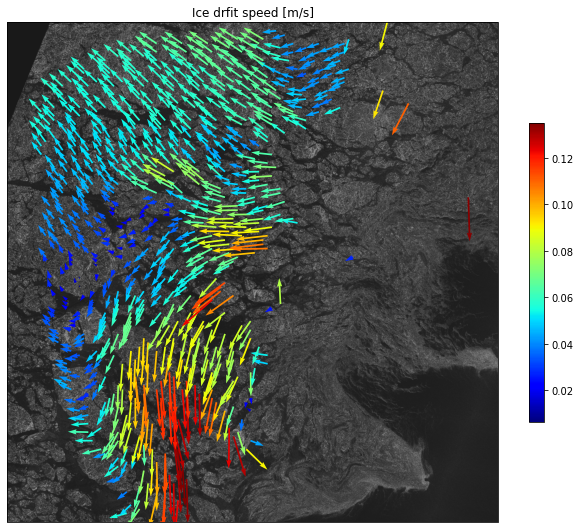

In [267]:
from matplotlib.patches import Rectangle

dayssec = 24*60*60

# compute ice drift speed [m/s]
delta_t = dayssec #in seconds
u = abs_error_dx / delta_t
v = abs_error_dy / delta_t 
speed = np.sqrt((v**2+u**2)) 
speed = np.copy(speed)
speed[speed > 0.1356] = np.nan

#(0.1356 is 95 percentile) 


# plot valid vectors in Polar stereographic projection
gpi = (hpm > 7) 
# X/Y grids in polar stereographic projection covering image_1
#x1pm, y1pm = dom_pm.get_geolocation_grids(dst_srs=srs)
#x1pm, y1pm = d.get_geolocation_grids(pm_step, dst_srs=srs)


# spacial reference for plotting
crs = ccrs.LambertConformal(central_longitude=-25,
    central_latitude=77.5,
    false_easting=0.0,
    false_northing=0.0,
    secant_latitudes=None,
    standard_parallels=(77.5, 77.5),
    globe=None)


plt.figure(figsize=(11,11))
ax = plt.axes(projection=crs)


ax.imshow(n1[1], cmap='gray', extent=[x1pm.min(), x1pm.max(), y1pm.min(), y1pm.max()], origin='upper') 
# Overlay a semi-transparent gray layer
gray_value = 0.2 # Midway between 0 (black) and 1 (white)
rect = Rectangle((x1pm.min(), y1pm.min()), x1pm.max() - x1pm.min(), y1pm.max() - y1pm.min(), facecolor=str(gray_value), alpha=0.5)
ax.add_patch(rect)
#plot every n_th vector
quiv=ax.quiver(x1pm[gpi][::6], y1pm[gpi][::6], u[gpi][::6], v[gpi][::6],speed[gpi][::6], scale=1.5, cmap='jet',width=0.0035) #, 
plt.colorbar(quiv, shrink=0.5)
plt.quiverkey(quiv, 110000, -770000, 0.05, '0.05 m/s', coordinates='data')
plt.title('Ice drfit speed [m/s]')
ax.add_feature(land_50m, edgecolor='black')
ax.set_xticks([-300000, -100000, 0, 100000, 300000])
ax.set_yticks([-700000, -500000, -300000])

#ax.set_xlim([x1pm.min(), x1pm.max()])
#ax.set_ylim([y1pm.min(), y1pm.max()])


ax.set_xlim([x1pm.min()+40000, x1pm.max()-70000])
ax.set_ylim([y1pm.min()+30000, y1pm.max()-60000])
plt.show()

In [ ]:
displacements = displacements[~np.any(np.isnan(displacements), axis=1), :]
displacements = displacements[~np.any(np.isinf(displacements), axis=1), :]